In [1]:
!python -m pip install --upgrade pip
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


> Now restart the notebook and continue from the next cell

In [ ]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.7/site-packages"

# Object Detection with RetinaNet

The task of object detection project involves drawing bounding boxes around objects and assigning labels to them.

In this project you will fine-tune a pre-trained RetinaNet model for  use on a self-driving car. In particular, we will use a subset of the Udacity self-driving car dataset.

The dataset contains 18000 training images and 4241 test images, of shape 480x300, corresponding to 132406 objects in the training set and 32699 objects in the test set. We are going to use 1/5th of the dataset in order to make the training achievable in a reasonable time frame for our class.

This is an example of an image from the dataset with the annotations:

<center><img src="notebook_ims/udacity_self_driving_example.png"></center>



In [2]:
from helpers import get_data_loaders, SelfDrivingDataset
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

from helpers import get_data_loaders

# The parameter "thinning" controls how much of the data we are
# actually using. A thinning of 1 means "use all of the data", 
# which would be optimal but very slow on this hardware. So we use
# thinning=5, i.e., we use one out of 5 images from the dataset
# (i.e. we reduce the dataset size by 5x). This is only for teaching
# purposes, to make the exercise complete in a reasonable time
data_loaders = get_data_loaders("data", batch_size=2, thinning=5)

#next(iter(data_loaders['train']))

Keeping 3600 of 18000 images
Keeping 26648 objects out of 132406
Keeping 3600 of 18000 images
Keeping 26648 objects out of 132406
Keeping 849 of 4241 images
Keeping 6528 objects out of 32699


These are the classes for this dataset:

In [3]:
print(data_loaders['train'].dataset.classes)

['car', 'truck', 'pedestrian', 'bicyclist', 'light']


## Defining the Model


<center><img src="notebook_ims/retinanet.png"></center>

In [4]:
import torchvision.models
import torch
import math

# Fetch a pre-trained RetinaNet based on Feature Pyramid Network ResNet50
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# In RetinaNet the background is a class of its own, so
# the number of classes is equal to the classes in the dataset
# plus 1
num_classes = len(data_loaders["train"].dataset.classes) + 1

# Get the number of inputs and the number of anchors from the existing
# classification head
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Set the number of classes to what we need
model.head.classification_head.num_classes = num_classes

# Create custom head
custom_head = torch.nn.Conv2d(
    in_features, num_anchors * num_classes, kernel_size=3, stride=1, padding=1
)

# Initialize weights and biass
# From the paper, see section 4.1 "Initialization" of https://arxiv.org/pdf/1708.02002.pdf
torch.nn.init.normal_(custom_head.weight, std=0.01)
torch.nn.init.constant_(custom_head.bias, -math.log((1 - 0.01) / 0.01))

# Replace existing head with the one we just created
model.head.classification_head.cls_logits = custom_head

/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model.load_state_dict(torch.load("pretrained.pth"))

<All keys matched successfully>

## Train



In [5]:
from torchvision_starter.engine import train_one_epoch, evaluate
from torchvision_starter import utils
import multiprocessing
import time

# Get number of CPUs on this machine
n_cpu = multiprocessing.cpu_count()

# Train on GPU preferentially, but fallback on CPU if GPU is not
# available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move model to the right device
_ = model.to(device)

# Setup the optimizer. Here we pre-filter to keep only parameters
# that need updating. This is not strictly necessary, but it is
# good practice to avoid surprises 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# The train_one_epoch function from engine.py has already a built-in
# scheduler which warms up for a bit (i.e., increase the learning rate
# from a very small value up to the initial value we have given Adam)
# This other LR scheduler decreases the learning rate every step_size
# epochs by multiplying the existing lr by gamma
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.2,
                                               verbose=True
                                              )
# Let's train for 10 epochs
num_epochs = 1

start = time.time()

for epoch in range(10, 10 + num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loaders['train'], device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loaders['valid'], device=device)

stop = time.time()

print(f"\n\n{num_epochs} epochs in {stop - start} s ({(stop-start) / 3600:.2f} hrs)")

Adjusting learning rate of group 0 to 1.0000e-05.


/home/pc/anaconda3/envs/deep-learning/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: [10]  [   0/1800]  eta: 0:25:57  lr: 0.000010  loss: 0.4607 (0.4607)  classification: 0.2118 (0.2118)  bbox_regression: 0.2489 (0.2489)  time: 0.8654  data: 0.3373  max mem: 1660
Epoch: [10]  [  10/1800]  eta: 0:09:03  lr: 0.000010  loss: 0.4230 (0.4179)  classification: 0.1291 (0.1567)  bbox_regression: 0.2673 (0.2613)  time: 0.3034  data: 0.0400  max mem: 2034
Epoch: [10]  [  20/1800]  eta: 0:08:08  lr: 0.000010  loss: 0.4230 (0.4549)  classification: 0.1587 (0.1811)  bbox_regression: 0.2636 (0.2738)  time: 0.2448  data: 0.0053  max mem: 2034
Epoch: [10]  [  30/1800]  eta: 0:07:49  lr: 0.000010  loss: 0.4364 (0.4464)  classification: 0.1728 (0.1744)  bbox_regression: 0.2636 (0.2720)  time: 0.2441  data: 0.0007  max mem: 2034
Epoch: [10]  [  40/1800]  eta: 0:07:36  lr: 0.000010  loss: 0.4437 (0.4455)  classification: 0.1599 (0.1691)  bbox_regression: 0.2874 (0.2764)  time: 0.2433  data: 0.0008  max mem: 2034
Epoch: [10]  [  50/1800]  eta: 0:07:27  lr: 0.000010  loss: 0.4195 (0.

## Performance Measures


```
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
```
This is the mean of all the mAP metrics obtained by varying the IoU between 0.5 and 0.95. The code builds one precision/recall curve for each value of IoU between 0.5 and 0.95 (in 0.05 increments) and then integrates it. This gives one mAP value for each IoU threshold. Then, the code takes the average of those. This is the main COCO competition metric, which you will find in many papers on object detection.

```
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
```
This is the mAP for one IoU threshold (50% in this case). The code builds the precision/recall curve for IoU=0.5 and integrates it.

```
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.346
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.866
```
These have the same meaning of the first quantity, however the measurement is given separately for small objects (< 32<sup>2</sup> pixel<sup>2</sup>), medium objects (32<sup>2</sup> < area < 96<sup>2</sup> pixel<sup>2</sup>), and large objects (> 96<sup>2</sup> pixel<sup>2</sup>). 

In this case our algorithm has a mAP of almost 90% for large objects (i.e., probably cars, people or lights that are close to the self-driving car).

For Average Recall we have:
```
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.486
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
```
These are the ARs considering at most 1, 10 and 100 detections per image. All the detections are sorted by confidence, then only the top 1, 10 or 100 are considered when computing AR. In our case, very few images (if any) have more than 100 objects, but a few have more than 10, so the last metric is the most meaningful.

Finally, we have this:
```
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.464
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.654
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.909
```
This is the AR given separately for small objects (< 32<sup>2</sup> pixel<sup>2</sup>), medium objects (32<sup>2</sup> < area < 96<sup>2</sup> pixel<sup>2</sup>), and large objects (> 96<sup>2</sup> pixel<sup>2</sup>).

In this case our algorithm has an AR of almost 91% for large objects (i.e., probably cars, people or lights that are close to the self-driving car).

## Visualize Some Results

Now that we have a pretty good model, let's visualize some results!

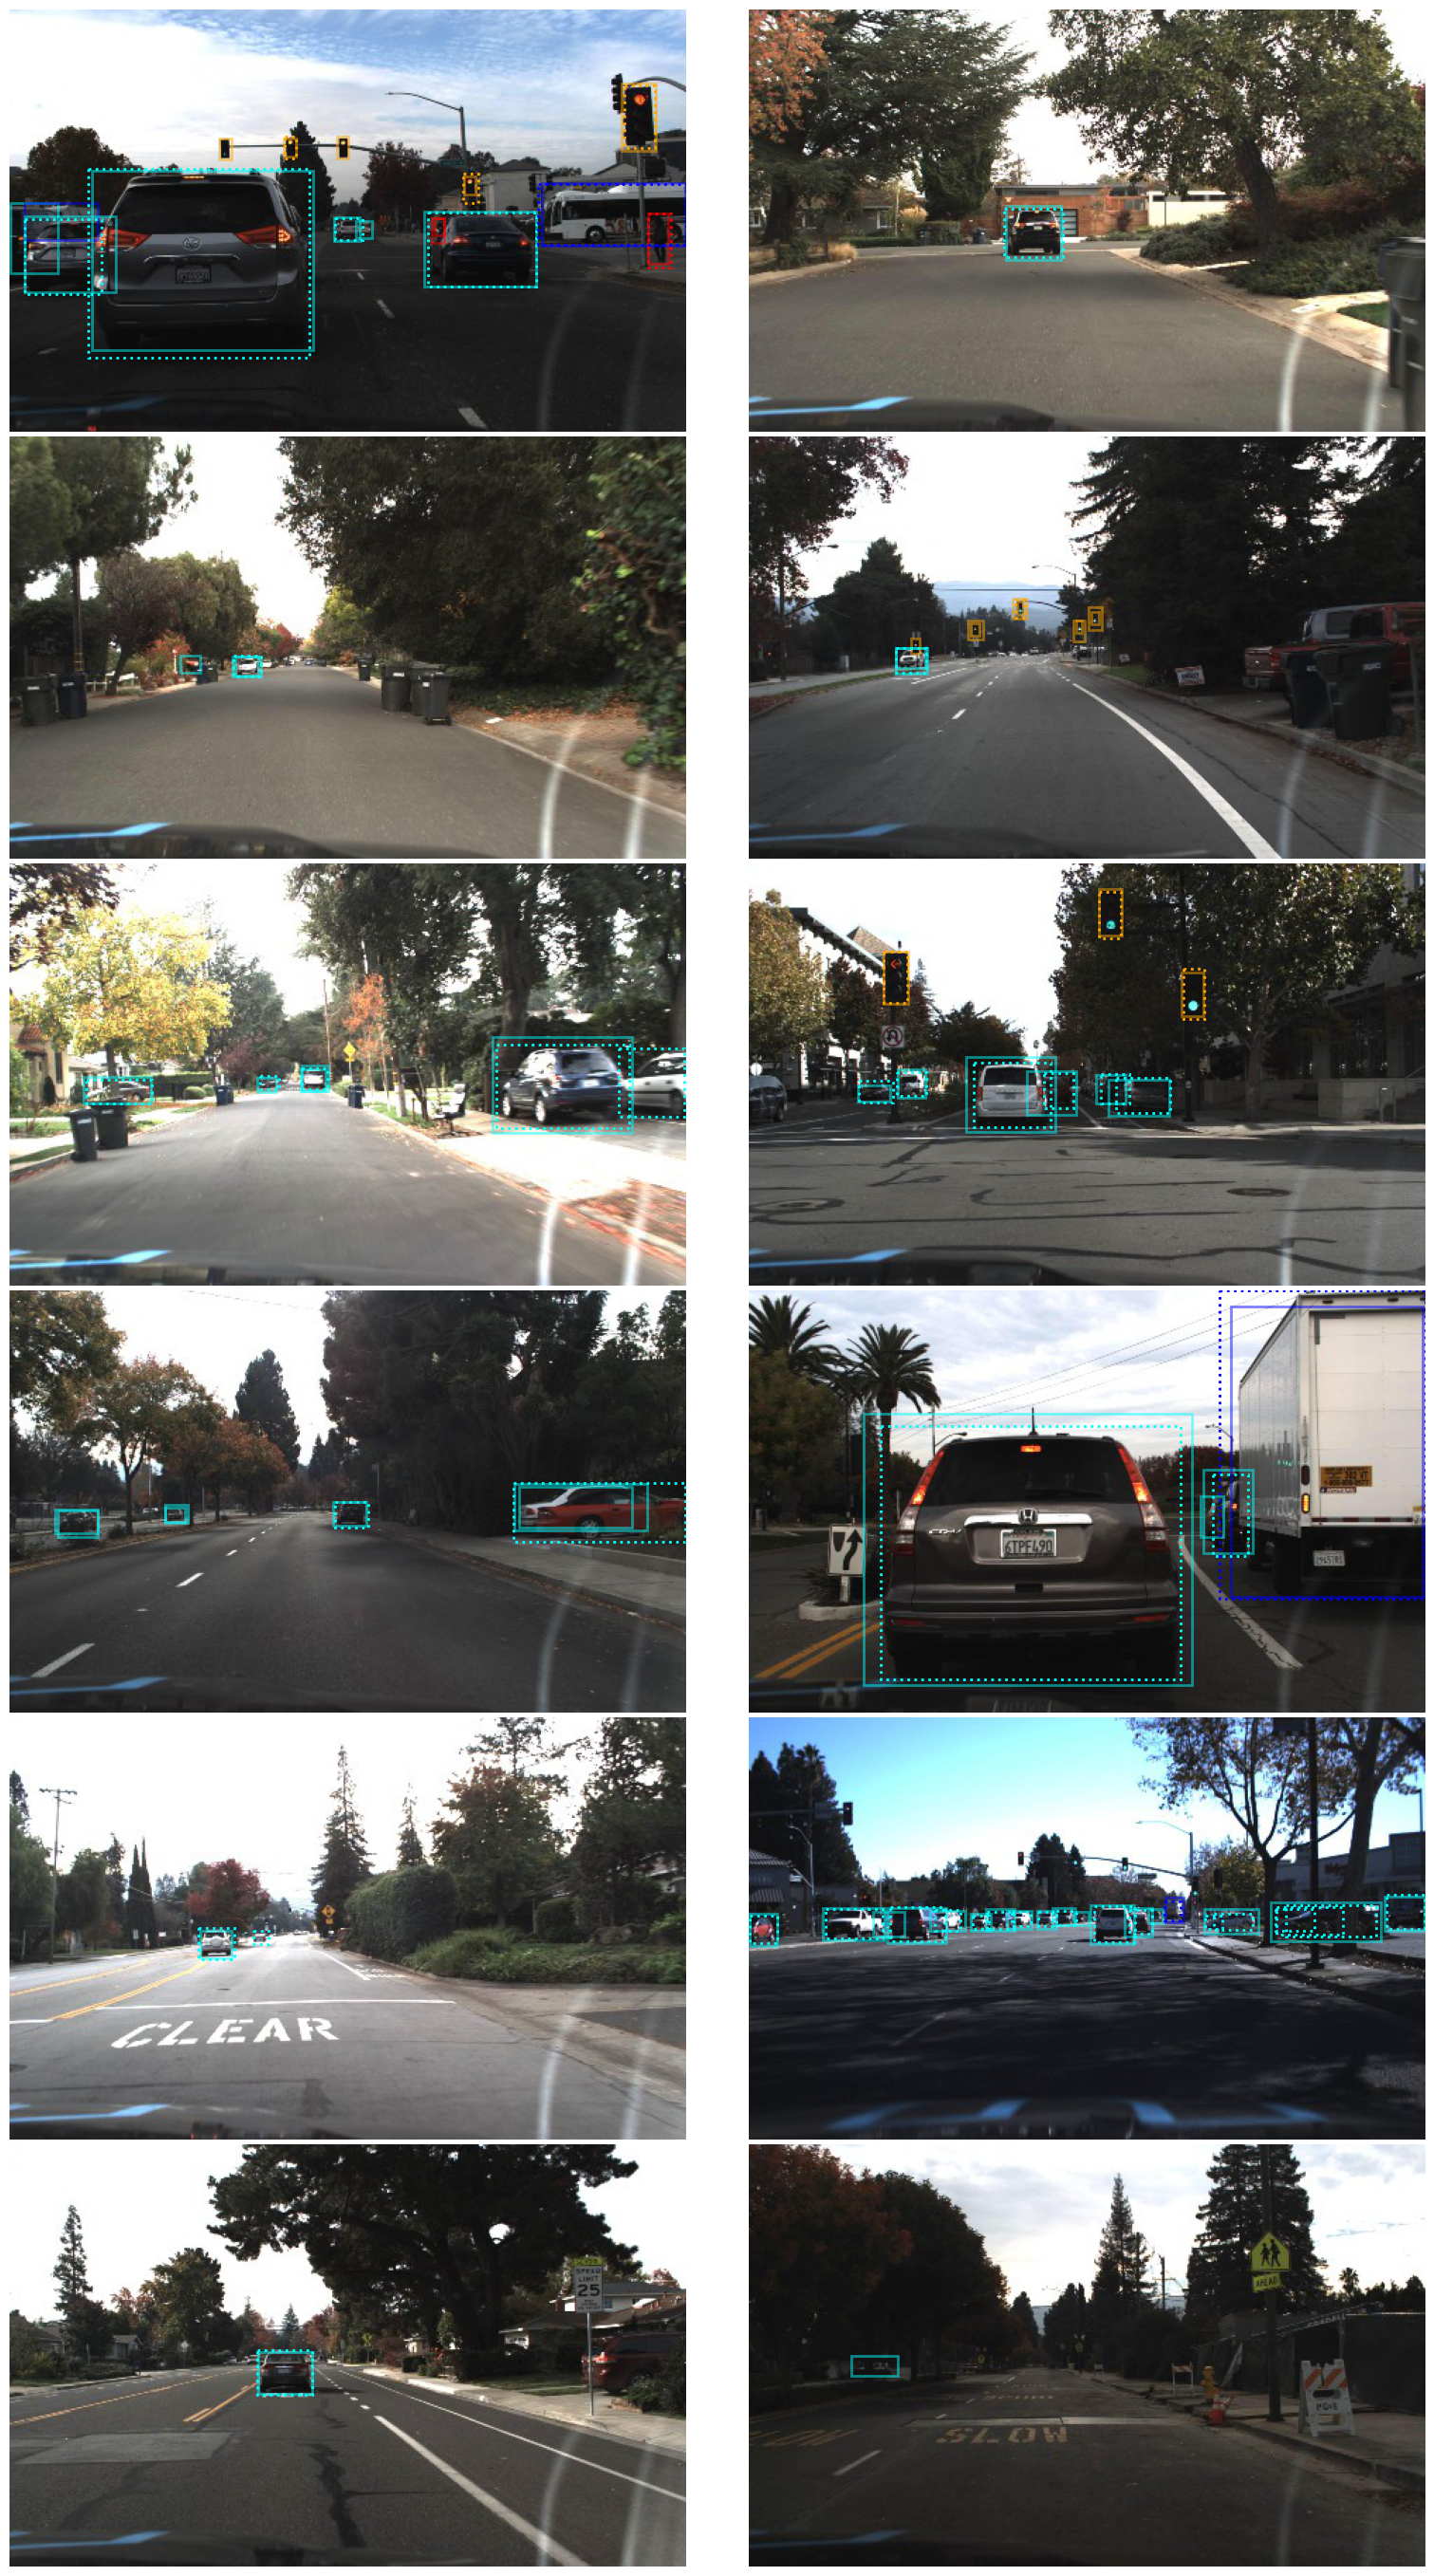

In [39]:
import matplotlib.pyplot as plt

model.eval()

fig, subs = plt.subplots(6, 2, figsize=(20, 35))
plt.subplots_adjust(wspace=0.01, hspace=0.01)

torch.manual_seed(42)

perm = torch.randperm(len(data_loaders['test'].dataset))
sel = perm[:subs.flatten().shape[0]]

for i, sub in zip(sel.squeeze(), subs.flatten()):
    
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_aspect('equal')

    image, labels = data_loaders['test'].dataset[i.item()]

    predictions = model([image])

    _ = data_loaders['test'].dataset.plot(i.item(), predictions=predictions[0], ax=sub)